In [62]:
# ## 1. Setup & Imports

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import joblib

# Optional: tensorflow for NN
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks
    TF_AVAILABLE = True
except Exception:
    TF_AVAILABLE = False

sns.set(style="whitegrid")

In [63]:
# ## 2. Load Dataset(s)

def load_csvs(path_or_folder):
    paths = []
    if os.path.isdir(path_or_folder):
        paths = sorted(glob.glob(os.path.join(path_or_folder, "*.csv")))
    elif os.path.isfile(path_or_folder):
        paths = [path_or_folder]
    else:
        raise FileNotFoundError(f"No such file or folder: {path_or_folder}")
    df_list = []
    for p in paths:
        df = pd.read_csv(p, comment="#", low_memory=False)
        df['__source'] = os.path.basename(p)
        df_list.append(df)
    df_all = pd.concat(df_list, ignore_index=True, sort=False)
    return df_all

csv_path = "cumulative_2025.10.04_14.13.06.csv"
df = load_csvs(csv_path)
print("Loaded data shape:", df.shape)
print("Columns:", df.columns.tolist())


Loaded data shape: (9564, 51)
Columns: ['loc_rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag', '__source']


Using disposition column: koi_disposition
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64


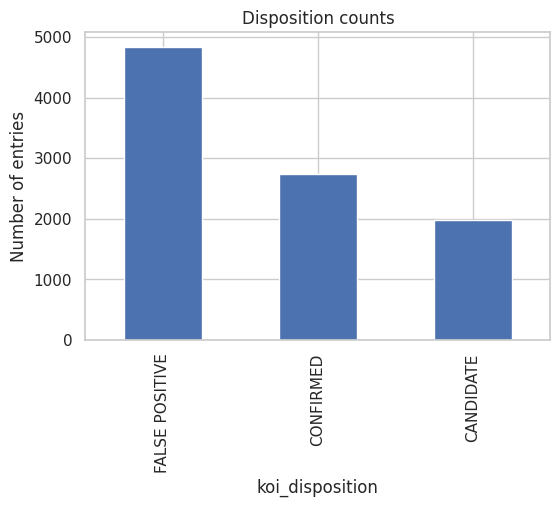

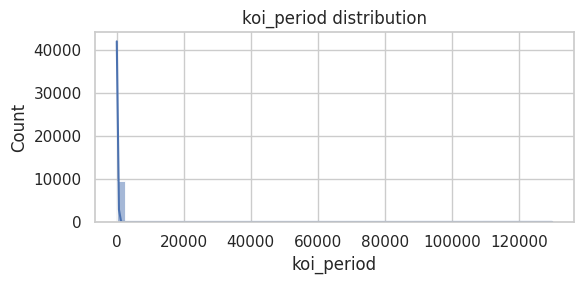

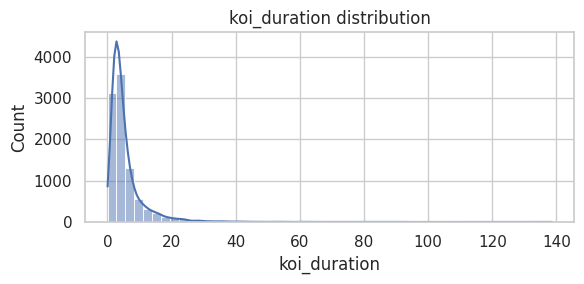

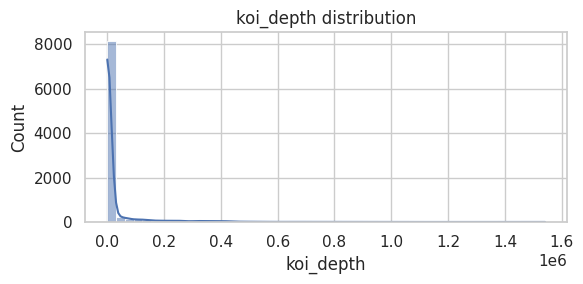

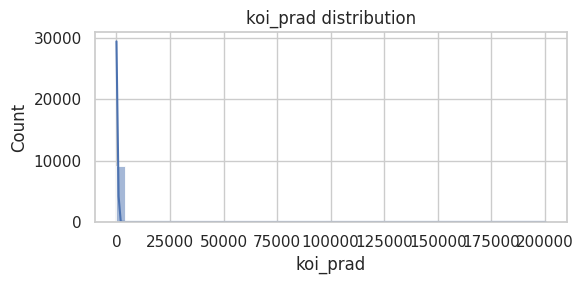

In [64]:
# Find disposition column
possible_disp = ['koi_disposition', 'disposition', 'tce_disposition', 'planet_flag']
disp_col = None
for c in possible_disp:
    if c in df.columns:
        disp_col = c
        break
# fallback: any column containing 'disp'
if disp_col is None:
    for c in df.columns:
        if 'disp' in c.lower():
            disp_col = c
            break

if disp_col is None:
    print("⚠️ No disposition column found.")
else:
    print("Using disposition column:", disp_col)

    # Show value counts
    print(df[disp_col].value_counts(dropna=False).head(20))

# Plot count of each class
plt.figure(figsize=(6,4))
df[disp_col].value_counts().plot(kind='bar')
plt.title("Disposition counts")
plt.ylabel("Number of entries")
plt.show()

# Show distributions of some numeric features (if present)
for feature in ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad']:
    if feature in df.columns:
        plt.figure(figsize=(6,3))
        sns.histplot(df[feature].dropna(), kde=True, bins=50)
        plt.title(f"{feature} distribution")
        plt.tight_layout()
        plt.show()

In [65]:
# Normalize disposition strings
def map_disp(s):
    if pd.isna(s):
        return None
    s2 = str(s).strip().upper()
    if s2 in ('CONFIRMED', 'TRUE POSITIVE', 'PLANET', 'CP', 'KP'):
        return 'CONFIRMED'
    if s2 in ('CANDIDATE', 'PC', 'PLANET CANDIDATE'):
        return 'CANDIDATE'
    if 'FALSE' in s2 or 'FP' in s2 or 'FALSE POSITIVE' in s2:
        return 'FALSE_POSITIVE'
    return 'OTHER'

df['disp_norm'] = df[disp_col].map(map_disp)
df = df[df['disp_norm'].notna()].copy()
print("After normalization, counts:\n", df['disp_norm'].value_counts())

# Example: binary label (planet vs non-planet)
df['label'] = (df['disp_norm'] == 'CONFIRMED').astype(int)

# Auto-selection of numeric features
numeric_feats = df.select_dtypes(include=[np.number]).columns.tolist()
# Drop identifiers or irrelevant ones
drop_prefixes = ['kepid','kic','tic','kepoi','koi_id','ra','dec','index']
use_feats = []
for c in numeric_feats:
    low = c.lower()
    if any(low.startswith(pref) for pref in drop_prefixes):
        continue
    if c == 'label':
        continue
    use_feats.append(c)
print("Numeric features considered:", use_feats)

# Optionally limit to a smaller set
feats = [f for f in use_feats if f in ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_srad', 'koi_steff']]
feats = feats if len(feats) > 0 else use_feats
print("Final features to use:", feats)


After normalization, counts:
 disp_norm
FALSE_POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64
Numeric features considered: ['loc_rowid', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'koi_kepmag']
Final features to use: ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_steff', 'koi_srad']


=== RandomForest ===
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1705
           1       0.82      0.71      0.76       686

    accuracy                           0.87      2391
   macro avg       0.85      0.82      0.83      2391
weighted avg       0.87      0.87      0.87      2391

ROC AUC: 0.9342715217632925


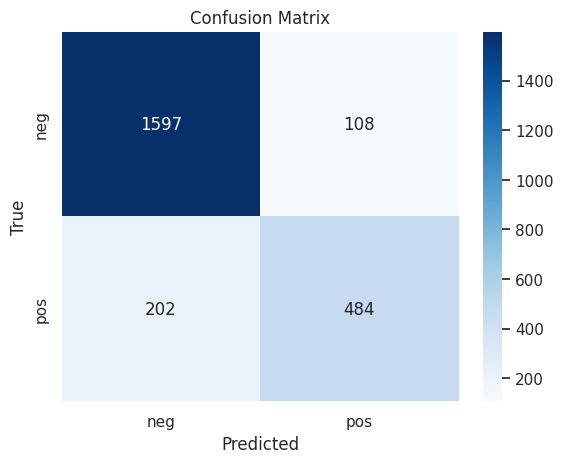

In [66]:
# Split
X = df[feats].copy()
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Preprocessing pipeline
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_train_s = scaler.fit_transform(imputer.fit_transform(X_train))
X_test_s = scaler.transform(imputer.transform(X_test))

# RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)
y_prob = rf.predict_proba(X_test_s)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

print("=== RandomForest ===")
print(classification_report(y_test, y_pred, zero_division=0))
try:
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception:
    pass

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg','pos'], yticklabels=['neg','pos'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [67]:
# Optional: Neural Network (if TF available)
if TF_AVAILABLE:
    print("Training small Dense NN...")
    tf.random.set_seed(42)
    input_dim = X_train_s.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    hist = model.fit(X_train_s, y_train, validation_split=0.15,
                     epochs=100, batch_size=32, callbacks=[es], verbose=1)
    y_prob_nn = model.predict(X_test_s).ravel()
    y_pred_nn = (y_prob_nn >= 0.5).astype(int)

    print("\n=== Neural Net ===")
    print(classification_report(y_test, y_pred_nn, zero_division=0))
    try:
        print("NN ROC AUC:", roc_auc_score(y_test, y_prob_nn))
    except Exception:
        pass


Training small Dense NN...
Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6794 - loss: 0.5899 - val_accuracy: 0.7230 - val_loss: 0.4992
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7148 - loss: 0.5175 - val_accuracy: 0.7481 - val_loss: 0.4756
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7315 - loss: 0.4946 - val_accuracy: 0.7602 - val_loss: 0.4590
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7328 - loss: 0.4821 - val_accuracy: 0.7658 - val_loss: 0.4500
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7456 - loss: 0.4727 - val_accuracy: 0.7658 - val_loss: 0.4438
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7329 - loss: 0.4745 - val_accuracy: 0.7695 - val_loss: 0.4415
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7411 - loss: 0.4690 - val_accuracy: 0.7686 - val_loss: 0.4386
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.747

In [68]:
# Save RF pipeline
pipeline = {
    'imputer': imputer,
    'scaler': scaler,
    'model': rf,
    'features': feats
}
joblib.dump(pipeline, "exoplanet_rf_pipeline.joblib")
print("Saved RF pipeline to exoplanet_rf_pipeline.joblib")

if TF_AVAILABLE:
    model.save("exoplanet_nn_model.h5")
    print("Saved NN model to exoplanet_nn_model.h5")

Saved RF pipeline to exoplanet_rf_pipeline.joblib
Saved NN model to exoplanet_nn_model.h5
